# Import Library

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import os

In [28]:
!pip install kaggle

In [29]:
!pip install graphviz

In [30]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"kaylaaisya","key":"b92c1f6e772ea6b87b19c608e7b8c4b6"}'}

# Import Dataset From Kaggle

In [31]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alperenmyung/social-media-advertisement-performance --unzip

# List files in the current directory
print("Files in the current directory:")
print(os.listdir())

# Assuming the CSV files are in the current directory after unzipping
csv_files = [f for f in os.listdir('.') if f.endswith('.csv')]

dataframes = {}
for csv_file in csv_files:
    try:
        df_name = os.path.splitext(csv_file)[0]
        dataframes[df_name] = pd.read_csv(csv_file)
        print(f"\nSuccessfully loaded {csv_file} into DataFrame '{df_name}'")
        print(f"First 5 rows of {df_name}:")
        display(dataframes[df_name].head())
    except Exception as e:
        print(f"Error loading {csv_file}: {e}")

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/alperenmyung/social-media-advertisement-performance
License(s): CC0-1.0
  0% 0.00/15.4M [00:00<?, ?B/s]
100% 15.4M/15.4M [00:00<00:00, 1.03GB/s]
Files in the current directory:
['.config', 'drive', 'campaigns.csv', 'ad_events.csv', 'users.csv', 'ads.csv', 'overall_funnel_flowchart.png', 'overall_funnel_chart.png', 'kaggle.json', 'ad_campaign_db.sqlite', 'facebook_funnel_flowchart.png.png', 'instagram_funnel_flowchart.png.png', 'kaggle (1).json', 'click_to_purchase_by_ad_type.json', 'funnel_flowchart.png', 'sample_data']

Successfully loaded campaigns.csv into DataFrame 'campaigns'
First 5 rows of campaigns:


,campaign_id,name,start_date,end_date,duration_days,total_budget
0,1,Campaign_1_Launch,2025-05-25,2025-07-23,59,24021.32
1,2,Campaign_2_Launch,2025-04-16,2025-07-07,82,79342.41
2,3,Campaign_3_Winter,2025-05-04,2025-06-29,56,14343.25
3,4,Campaign_4_Summer,2025-06-04,2025-08-08,65,45326.60
4,5,Campaign_5_Launch,2025-07-11,2025-08-28,48,68376.69



Successfully loaded ad_events.csv into DataFrame 'ad_events'
First 5 rows of ad_events:


,event_id,ad_id,user_id,timestamp,day_of_week,time_of_day,event_type
0,1,197,2359b,2025-07-26 00:19:56,Saturday,Night,Like
1,2,51,f9c67,2025-06-15 08:28:07,Sunday,Morning,Share
2,3,46,5b868,2025-06-27 00:40:02,Friday,Night,Impression
3,4,166,3d440,2025-06-05 19:20:45,Thursday,Evening,Impression
4,5,52,68f1a,2025-07-22 08:30:29,Tuesday,Morning,Impression



Successfully loaded users.csv into DataFrame 'users'
First 5 rows of users:


,user_id,user_gender,user_age,age_group,country,location,interests
0,a2474,Female,24,18-24,United Kingdom,New Mariomouth,"fitness, health"
1,141e5,Male,21,18-24,Germany,Danielsfort,"food, fitness, lifestyle"
2,34db0,Male,27,25-34,Australia,Vincentchester,"fashion, news"
3,20d08,Female,28,25-34,India,Lisaport,"health, news, finance"
4,9e830,Male,28,25-34,United States,Brownmouth,"health, photography, lifestyle"



Successfully loaded ads.csv into DataFrame 'ads'
First 5 rows of ads:


,ad_id,campaign_id,ad_platform,ad_type,target_gender,target_age_group,target_interests
0,1,28,Facebook,Video,Female,35-44,"art, technology"
1,2,33,Facebook,Stories,All,25-34,"travel, photography"
2,3,20,Instagram,Carousel,All,25-34,technology
3,4,28,Facebook,Stories,Female,25-34,news
4,5,24,Instagram,Image,Female,25-34,news


# Calculate Conversion Rates

In [32]:
def get_segmented_funnel(df, segment_by):
    """
    Calculates a 3-stage funnel (Impression, Click, Purchase) by unique users,
    segmented by a given column.

    Returns a DataFrame with counts and conversion rates for each segment.
    """

    # Group by the segment column
    grouped = df.groupby(segment_by)

    # Dictionary to hold our results
    funnel_results = {}

    for name, group in grouped:
        # Get unique users at each stage *within that group*
        users_impression = set(group[group['event_type'] == 'Impression']['user_id'].unique())
        users_click = set(group[group['event_type'] == 'Click']['user_id'].unique())
        users_purchase = set(group[group['event_type'] == 'Purchase']['user_id'].unique())

        # Apply the waterfall logic (users must pass previous stage)
        users_click_waterfall = users_impression.intersection(users_click)
        users_purchase_waterfall = users_click_waterfall.intersection(users_purchase)

        # Count the users
        n_impression = len(users_impression)
        n_click = len(users_click_waterfall)
        n_purchase = len(users_purchase_waterfall)

        # Calculate Conversion Rates (CR)
        # Impression -> Click
        imp_to_click_cr = (n_click / n_impression) * 100 if n_impression > 0 else 0

        # Click -> Purchase
        click_to_purchase_cr = (n_purchase / n_click) * 100 if n_click > 0 else 0

        # Overall: Impression -> Purchase
        overall_cr = (n_purchase / n_impression) * 100 if n_impression > 0 else 0

        # Store results
        funnel_results[name] = {
            'Impressions': n_impression,
            'Clicks': n_click,
            'Purchases': n_purchase,
            'Imp_to_Click_CR (%)': imp_to_click_cr,
            'Click_to_Purchase_CR (%)': click_to_purchase_cr,
            'Overall_CR (%)': overall_cr
        }

    # Convert results to a DataFrame
    df_result = pd.DataFrame.from_dict(funnel_results, orient='index')
    # Sort by the most important metric: Purchases
    df_result = df_result.sort_values(by='Purchases', ascending=False)

    return df_result

# Funnel Analysis

--- Step 1: Loading Data ---
All data files loaded successfully.

--- Step 2: Building Overall Funnel ---

Overall Funnel (Unique Users per Stage):
        Stage  Users
0  Impression   9950
1       Click   9772
2    Purchase   1806

--- Step 3: Calculating Overall Conversion Rates ---

Funnel with Conversion Rates and Drop-offs:
        Stage  Users  Stage-to-Stage CR (%)  Drop-off (Users)  Drop-off (%)
0  Impression   9950             100.000000                 0      0.000000
1       Click   9772              98.211055               178      1.788945
2    Purchase   1806              18.481375              7966     81.518625

Overall Conversion Rate (Purchase / Impression): 18.1508%

--- Step 4: Visualizing the Overall Funnel ---


/tmp/ipython-input-1635717886.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


Saved funnel chart to 'overall_funnel_chart.png'

--- Step 4b: Creating Funnel Flowchart ---
Saved flowchart to 'funnel_flowchart.png'

--- Step 5: Merging all DataFrames ---
Merge complete.

--- Step 6: Running Segmented Analysis ---

--- Funnel by Ad Platform ---
           Impressions  Clicks  Purchases  Imp_to_Click_CR (%)  Click_to_Purchase_CR (%)  Overall_CR (%)
Facebook          9950    9156       1146            92.020101                 12.516383       11.517588
Instagram         9950    7633        521            76.713568                  6.825626        5.236181

--- Funnel by Ad Type ---
          Impressions  Clicks  Purchases  Imp_to_Click_CR (%)  Click_to_Purchase_CR (%)  Overall_CR (%)
Stories          9950    7179        468            72.150754                  6.519014        4.703518
Carousel         9949    6371        329            64.036587                  5.164024        3.306865
Image            9948    6483        295            65.168878                  4

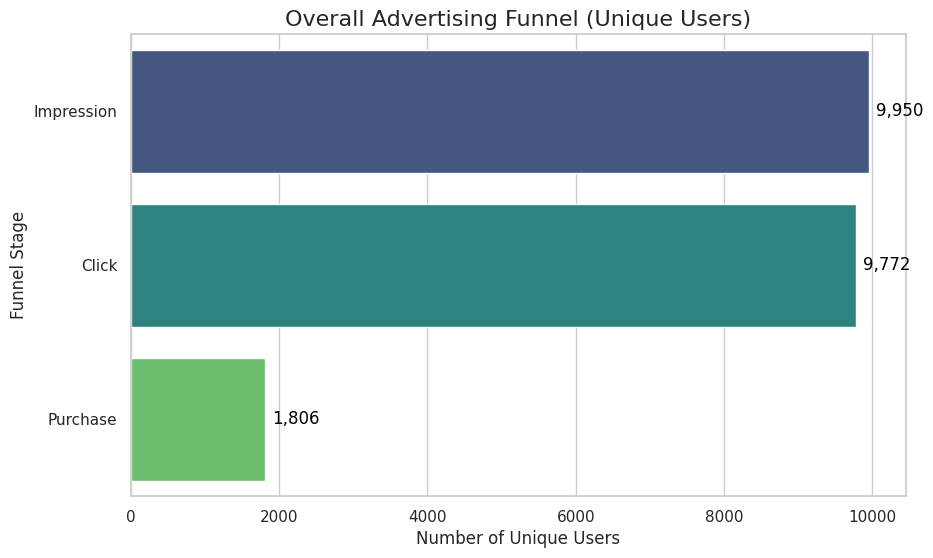

In [33]:
def main():
    """
    Main function to run the full funnel analysis.
    """
    # Set plot style
    sns.set(style="whitegrid")

    # --- Step 1: Load Data ---
    print("--- Step 1: Loading Data ---")
    try:
        df_events = pd.read_csv("ad_events.csv")
        df_ads = pd.read_csv("ads.csv")
        df_campaigns = pd.read_csv("campaigns.csv")
        df_users = pd.read_csv("users.csv")
        print("All data files loaded successfully.")
    except FileNotFoundError as e:
        print(f"Error: {e}.")
        print("Please ensure all CSV files (ad_events.csv, ads.csv, campaigns.csv, users.csv) are in the same directory.")
        return
    except Exception as e:
        print(f"An error occurred during loading: {e}")
        return

    # --- Step 2: Build the Overall Funnel ---
    print("\n--- Step 2: Building Overall Funnel ---")

    # Define the funnel stages
    funnel_stages = ['Impression', 'Click', 'Purchase']
    funnel_users = {}

    for stage in funnel_stages:
        stage_events = df_events[df_events['event_type'] == stage]
        unique_users_at_stage = set(stage_events['user_id'].unique())
        funnel_users[stage] = unique_users_at_stage

    # Apply waterfall logic for unique users
    users_impression = funnel_users['Impression']
    users_click = users_impression.intersection(funnel_users['Click'])
    users_purchase = users_click.intersection(funnel_users['Purchase'])

    funnel_data = {
        'Stage': funnel_stages,
        'Users': [len(users_impression), len(users_click), len(users_purchase)]
    }
    df_funnel = pd.DataFrame(funnel_data).sort_values(by='Users', ascending=False)
    print("\nOverall Funnel (Unique Users per Stage):")
    print(df_funnel.to_string())

    # --- Step 3: Calculate & Print Overall Conversion Rates ---
    print("\n--- Step 3: Calculating Overall Conversion Rates ---")
    df_funnel['Prev_Stage_Users'] = df_funnel['Users'].shift(1)
    df_funnel['Stage-to-Stage CR (%)'] = (df_funnel['Users'] / df_funnel['Prev_Stage_Users']) * 100
    df_funnel['Stage-to-Stage CR (%)'] = df_funnel['Stage-to-Stage CR (%)'].fillna(100)
    df_funnel['Drop-off (Users)'] = (df_funnel['Prev_Stage_Users'] - df_funnel['Users']).fillna(0).astype(int)
    df_funnel['Drop-off (%)'] = (df_funnel['Drop-off (Users)'] / df_funnel['Prev_Stage_Users']) * 100
    df_funnel['Drop-off (%)'] = df_funnel['Drop-off (%)'].fillna(0)

    overall_cr = (len(users_purchase) / len(users_impression)) * 100 if len(users_impression) > 0 else 0

    print("\nFunnel with Conversion Rates and Drop-offs:")
    print(df_funnel[['Stage', 'Users', 'Stage-to-Stage CR (%)', 'Drop-off (Users)', 'Drop-off (%)']].to_string())
    print(f"\nOverall Conversion Rate (Purchase / Impression): {overall_cr:.4f}%")

    # --- Step 4: Visualize the Overall Funnel ---
    print("\n--- Step 4: Visualizing the Overall Funnel ---")
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("viridis", n_colors=len(df_funnel))
    bar_plot = sns.barplot(
        x='Users',
        y='Stage',
        data=df_funnel,
        palette=colors,
        order=df_funnel['Stage']
    )
    for index, row in df_funnel.iterrows():
        bar_plot.text(row['Users'] + (0.01 * df_funnel['Users'].max()), index, f"{row['Users']:,}", color='black', ha="left", va="center")

    plt.title('Overall Advertising Funnel (Unique Users)', fontsize=16)
    plt.xlabel('Number of Unique Users', fontsize=12)
    plt.ylabel('Funnel Stage', fontsize=12)

    chart_filename = 'overall_funnel_chart.png'
    plt.savefig(chart_filename, bbox_inches='tight')
    print(f"Saved funnel chart to '{chart_filename}'")

    # --- Step 4b: Create Flowchart Visualization ---
    if GRAPHVIZ_AVAILABLE:
        print("\n--- Step 4b: Creating Funnel Flowchart ---")
        dot = graphviz.Digraph(comment='Ad Funnel Flowchart')
        dot.attr(rankdir='LR') # Left-to-Right layout

        # Add nodes
        for index, row in df_funnel.iterrows():
            dot.node(
                row['Stage'],
                f"{row['Stage']}\n{row['Users']:,} Users",
                shape='box',
                style='filled',
                color='skyblue'
            )

        # Add edges with conversion and drop-off info
        for i in range(len(df_funnel) - 1):
            row_current = df_funnel.iloc[i]
            row_next = df_funnel.iloc[i+1]

            cr = row_next['Stage-to-Stage CR (%)']
            drop_users = row_next['Drop-off (Users)']
            drop_pct = row_next['Drop-off (%)']

            dot.edge(
                row_current['Stage'],
                row_next['Stage'],
                label=f" CR: {cr:.2f}%\nDrop: {drop_users:,} ({drop_pct:.2f}%) "
            )

        try:
            dot.render('funnel_flowchart', format='png', cleanup=True)
            print("Saved flowchart to 'funnel_flowchart.png'")
        except Exception as e:
            print(f"Error rendering flowchart: {e}")
            print("Graphviz might not be installed correctly or 'dot' executable is missing from PATH.")

    # --- Step 5: Merge All DataFrames for Segmented Analysis ---
    print("\n--- Step 5: Merging all DataFrames ---")
    df_merged = pd.merge(df_events, df_ads, on='ad_id', how='left')
    df_merged = pd.merge(df_merged, df_campaigns, on='campaign_id', how='left')
    df_merged = pd.merge(df_merged, df_users, on='user_id', how='left')
    print("Merge complete.")

    # --- Step 6: Run Segmented Analysis ---
    print("\n--- Step 6: Running Segmented Analysis ---")

    print("\n--- Funnel by Ad Platform ---")
    df_funnel_platform = get_segmented_funnel(df_merged, 'ad_platform')
    print(df_funnel_platform.to_string())

    print("\n--- Funnel by Ad Type ---")
    df_funnel_ad_type = get_segmented_funnel(df_merged, 'ad_type')
    print(df_funnel_ad_type.to_string())

    print("\n--- Funnel by Country ---")
    df_funnel_country = get_segmented_funnel(df_merged, 'country')
    print(df_funnel_country.sort_values(by='Purchases', ascending=False).to_string())

    print("\n--- Funnel by User Age Group ---")
    df_funnel_age_group = get_segmented_funnel(df_merged, 'age_group')
    print(df_funnel_age_group.to_string())

    print("\n--- Funnel by User Gender ---")
    df_funnel_gender = get_segmented_funnel(df_merged, 'user_gender')
    print(df_funnel_gender.to_string())

    # --- Step 7: Visualize Key Segment ---
    print("\n--- Step 7: Visualizing Key Segment Performance ---")
    df_plot_ad_type = df_funnel_ad_type.reset_index().rename(columns={'index': 'Ad Type'})

    chart = alt.Chart(df_plot_ad_type).mark_bar().encode(
        x=alt.X('Ad Type:N', sort='-y'), # Sort by descending CR
        y=alt.Y('Click_to_Purchase_CR (%)', title='Click-to-Purchase Conversion Rate (%)'),
        color='Ad Type:N',
        tooltip=['Ad Type', 'Click_to_Purchase_CR (%)', 'Purchases', 'Clicks']
    ).properties(
        title='Key Funnel Leak: Click-to-Purchase Rate by Ad Type'
    ).interactive()

    chart_json_path = 'click_to_purchase_by_ad_type.json'
    chart.save(chart_json_path)
    print(f"Saved key segment chart to '{chart_json_path}'")
    print("\n--- Analysis Complete ---")

if __name__ == "__main__":
    main()